In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_2_TwoSequences import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', **{'family': 'serif', 'size': 20})
mpl.rcParams.update({'font.size': 20})
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sim = sim_wc.Simulator(params)
sim.set_interaction_matrix()
t, r = sim.run()
r = r.T

### Show example

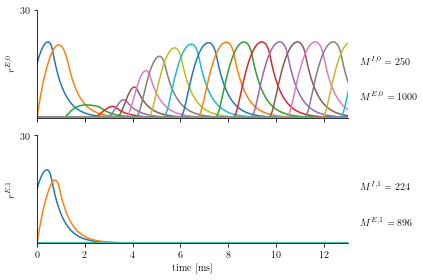

In [3]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, squeeze=False)
   
rE = r[:, ::2]
for i, seq_i in enumerate(params['seqs']):
    rE_i = rE[:, seq_i]
    #plot rates
    ax[i, 0].plot(t,  rE_i[:, ::1])
    
    # annotate
    ax[i, 0].set_ylabel(r'$r^{E,'+str(i)+'}$')
    ax[i, 0].spines['right'].set_visible(False)
    ax[i, 0].spines['top'].set_visible(False)
    
    ax[i, 0].text(13.5, 5., r'$M^{E,'+str(i)+'} = '+str(params['nE'][i])+'$')
    ax[i, 0].text(13.5, 15., r'$M^{I,'+str(i)+'} = '+str(params['nI'][i])+'$')

ax[i, 0].set_yticks([30])
ax[-1, 0].set_ylim(0, 30)
ax[-1, 0].set_xlim(0, 13)
ax[-1, 0].set_xlabel('time [ms]')
fig.tight_layout()

plt.savefig('figures/2b_Competition_example.svg')

#### Reduced inhibition explains extended activity of last assembly

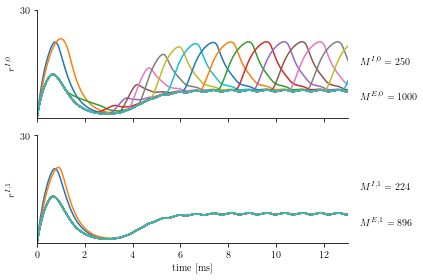

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, squeeze=False)
   
rI = r[:, 1::2]
for i, seq_i in enumerate(params['seqs']):
    rI_i = rI[:, seq_i]
    #plot rates
    ax[i, 0].plot(t,  rI_i[:, ::1])
    
    # annotate
    ax[i, 0].set_ylabel(r'$r^{I,'+str(i)+'}$')
    ax[i, 0].spines['right'].set_visible(False)
    ax[i, 0].spines['top'].set_visible(False)
    
    ax[i, 0].text(13.5, 5., r'$M^{E,'+str(i)+'} = '+str(params['nE'][i])+'$')
    ax[i, 0].text(13.5, 15., r'$M^{I,'+str(i)+'} = '+str(params['nI'][i])+'$')

ax[i, 0].set_yticks([30])
ax[-1, 0].set_ylim(0, 30)
ax[-1, 0].set_xlim(0, 13)
ax[-1, 0].set_xlabel('time [ms]')

fig.tight_layout()

plt.savefig('figures/2b_Competition_example_inh.svg')

### Scan parameter range

In [5]:
fname_res = 'data/2_r_twoseqs.pckl'

t = params['t']


In [6]:
load_res = True

if load_res:
    r = tools_wc.load_pckl(fname_res)
    
else:
    r = np.zeros([
        len(params['range_nE0']),
        len(params['range_nE1']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])

    for i, nE_0 in enumerate(tqdm(params['range_nE0'])):
        for j, nE_1 in enumerate(params['range_nE1']):
            sim = sim_wc.Simulator(params)
            sim.p['nE'] = [nE_0, nE_1]
            sim.p['nI'] = [int(nE_0*0.25), int(nE_1*0.25)]
            sim.set_interaction_matrix()
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
    tools_wc.save_pckl(r, fname_res)

100%|███████████████████████████████████████████████████████████████████| 16/16 [04:13<00:00, 15.84s/it]


In [7]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_nE0']),
    len(params['range_nE1']),
    len(params['seqs'])
], dtype=bool)

dt = np.mean(np.unique(np.diff(params['t'])))

for i, nE_i in enumerate(params['range_nE0']):
    for j, nE_j in enumerate(params['range_nE1']):
        for m, seq_m in enumerate(params['seqs']):
            rE_ijm = rE[i, j, :, :][:, seq_m]  
            seq_m_pos = seq_m - seq_m[0]
            crit[i, j, m] = tools_wc.peak_criterium(rE_ijm, params['r_min'], seq_m_pos, params['tol'])

In [8]:
cmap = mpl.cm.get_cmap('Greys')

cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0, 0.9, 1.1, 2., 3.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

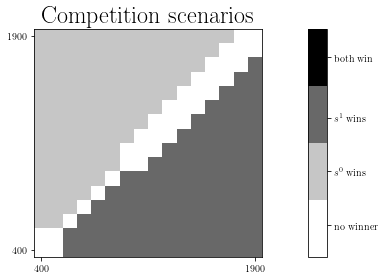

In [9]:
piv = np.sum(crit, axis=2)
f = 0.1
piv = piv - f*crit[:, :, 0]
piv = piv + f*crit[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]})


ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(params['range_nE1'], params['range_nE0'], piv, cmap=cmap, norm=norm)
#ax[0,0].set_ylabel(r'n^{E,0}$')
#ax[0,0].set_xlabel(r'n^{E,1}$')
ax[0,0].set_xticks([params['range_nE0'][0], params['range_nE0'][-1]])
ax[0,0].set_yticks([params['range_nE1'][0], params['range_nE1'][-1]])
ax[0,0].set_title('Competition scenarios', fontsize=24)

ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    ticks=[0.5, 1., 1.5, 2.5],
    boundaries=bounds, format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ wins',
     'both win'])

fig.tight_layout()

fig.savefig('figures/2_competitionScenarios.svg')

### Extend parameter scan 

In [10]:
fname_res = 'data/2_r_twoseqs_extended.pckl'

In [14]:
load_res = True

if load_res:
    r_all = tools_wc.load_pckl(fname_res)
    
else:
    r_all={}

    t = params['t']
    for s in ['range_p_ff', 'range_p_rc', 'range_p_ffi']:
        print(s)

        r = np.zeros([
            len(params[s]),
            len(params['range_nE0']),
            len(params['range_nE1']),
            len(t),
            len(np.concatenate(params['seqs']))*2,
            ])
        for h, val_h in enumerate(tqdm(params[s])):
            for i, nE_0 in enumerate(params['range_nE0']):
                for j, nE_1 in enumerate(params['range_nE1']):
                    sim = sim_wc.Simulator(params)
                    sim.p[s[6:]] = val_h
                    sim.p['nE'] = [nE_0, nE_1]
                    sim.p['nI'] = [int(nE_0*0.25), int(nE_1*0.25)]
                    sim.set_interaction_matrix()
                    _, r_shij = sim.run()
                    r[h, i, j, :, :] = r_shij.T
        r_all[s] = r
    
    tools_wc.save_pckl(r_all, fname_res)

range_p_ff


100%|██████████████████████████████████████████████████████████████████| 15/15 [27:18<00:00, 109.26s/it]


range_p_rc


100%|██████████████████████████████████████████████████████████████████| 15/15 [27:42<00:00, 110.83s/it]


range_p_ffi


100%|██████████████████████████████████████████████████████████████████| 20/20 [36:59<00:00, 111.00s/it]


In [15]:
# evaluate successful progression

r_all['range_p_rc'].shape

(15, 16, 16, 1500, 120)

In [16]:
crit_all={}
cond_all={}
mean_t_act_all={}

dt = np.mean(np.unique(np.diff(params['t'])))

for s in ['range_p_ff', 'range_p_rc', 'range_p_ffi']:
    print(s)

    crit_s = np.zeros([
        len(params[s]),
        len(params['range_nE0']),
        len(params['range_nE1']),
        len(params['seqs'])
        ])
    
    cond_s = np.zeros([
        len(params[s]),
        len(params['range_nE0']),
        len(params['range_nE1']),
        len(params['seqs']),
        4], dtype=bool)
    mean_t_act_s = np.zeros([
        len(params[s]),
        len(params['range_nE0']),
        len(params['range_nE1']),
        len(params['seqs'])])
    
    
    for h, val_h in enumerate(tqdm(params[s])):
        for i, nE_0 in enumerate(params['range_nE0']):
            for j, nE_1 in enumerate(params['range_nE1']):
                for m, seq_m in enumerate(params['seqs']):
                    
                    rE_shijm = r_all[s][h, i, j, :, ::2][:, seq_m]                
                    seq_m_pos = seq_m - seq_m[0]                

                    (crit_s[h, i, j, m],
                     cond_s[h, i, j, m, 0],
                     cond_s[h, i, j, m, 1],
                     cond_s[h, i, j, m, 2],
                     cond_s[h, i, j, m, 3]) = tools_wc.peak_criterium(
                        rE_shijm, params['r_min'], seq_m_pos, params['tol'],
                        return_conds=True)
    
                    mean_t_act_s[h, i, j, m] = tools_wc.mean_activation_time(
                        rE_shijm, params['r_min'], dt)
                    
    crit_all[s] = crit_s
    cond_all[s] = cond_s
    mean_t_act_all[s] = mean_t_act_s

range_p_ff


100%|███████████████████████████████████████████████████████████████████| 15/15 [01:14<00:00,  4.95s/it]


range_p_rc


100%|███████████████████████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.76s/it]


range_p_ffi


100%|███████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.99s/it]


In [17]:
cnts_cumsum = {}

ls = ['range_p_ff', 'range_p_rc', 'range_p_ffi']
bin_edges = [0, 0.89, 0.91, 1.11, 2.1]

for i, par_i in enumerate(ls):
    cnts = []
    for j, val_j in enumerate(params[par_i]):
        crit_j = crit_all[par_i][j]
        piv = np.sum(crit_j, axis=2)
        f = 0.1
        piv -= f*crit_j[:, :, 0]
        piv += f*crit_j[:, :, 1]
        cnts_j, _ = np.histogram(piv.flatten(), bin_edges)
        n_all = len(params['range_nE0'])*len(params['range_nE1'])
        cnts_j = cnts_j/n_all
        cnts.append(cnts_j)
    cnts = np.vstack(cnts)
    cnts_cumsum[par_i] = np.cumsum(cnts, axis=1)

/tmp/ipykernel_15985/258838615.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


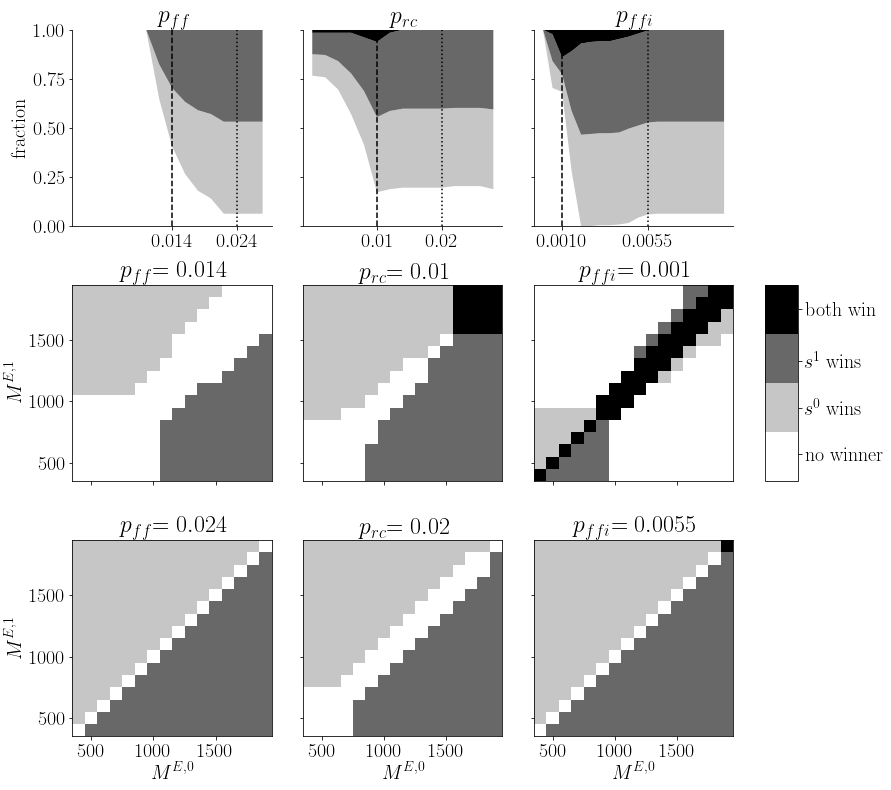

In [44]:
fig, ax = plt.subplots(
    3, 4, figsize=(13,13), squeeze=False,
    gridspec_kw={
        'width_ratios': [0.3, 0.3, 0.3, 0.05],
        'hspace': 0.3})
ls = ['range_p_ff', 'range_p_rc', 'range_p_ffi']
ls_ltx = ['$p_{ff}$', '$p_{rc}$', '$p_{ffi}$']

# vertical bars to indicate position of excerpts
bars_vert = {
    'range_p_ff': [7, 12],
    'range_p_rc': [5, 10],
    'range_p_ffi': [2, 11],
}
ls_linestyle = ['--', ':']

for i, par_i in enumerate(ls):
    cnts_cumsum_i = cnts_cumsum[par_i]
    ax_i = ax[0, i]
    ax_i.set_title(ls_ltx[i])
    x = params[par_i]
    
    for j in range(cnts_cumsum_i.shape[1]-1):
        ax_i.fill_between(
            x,
            cnts_cumsum_i[:, j],
            cnts_cumsum_i[:, j+1],
            facecolor=cmaplist[norm(bounds[j+1])],
            interpolate=False)
        
    ax_i.set_ylim(0, 1)
    ax_i.set_xticks(list(params[par_i][bars_vert[par_i]]))
#    ax_i.tick_params(axis='x', rotation=20)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['top'].set_visible(False)
    if i > 0:
        ax_i.set_yticklabels([])
        
    for j, val_j in enumerate(bars_vert[par_i]):
        crit_i = crit_all[par_i][val_j]
        
        piv = np.sum(crit_i, axis=2)
        f = 0.1
        piv -= f*crit_i[:, :, 0]
        piv += f*crit_i[:, :, 1]

        heatmap = ax[j+1, i].pcolormesh(params['range_nE1'], params['range_nE0'], piv, cmap=cmap, norm=norm)
        
        ax[j+1, i].set_ylabel(str(val_j))
        #ax[j+1, i].spines['right'].set_visible(False)
        #ax[j+1, i].spines['top'].set_visible(False)
        if i>0:
            ax[j+1, i].set_yticklabels([])
            #ax[j+1, i].spines['left'].set_visible(False)
            #ax[j+1, i].set_yticks([])
            ax[j+1, i].set_ylabel('')
        else:
            ax[j+1, i].set_ylabel(r'$M^{E,1}$')
            
        if j<1:
            ax[j+1, i].set_xticklabels([])
        else:
            ax[j+1, i].set_xlabel(r'$M^{E,0}$')
        ax[j+1, i].set_title(ls_ltx[i] + '$ = ' + str(params[par_i][val_j])+'$')
        ax[0, i].axvline(params[par_i][val_j], color='k', linestyle=ls_linestyle[j])

ax[0, -1].axis('off')
ax[2, -1].axis('off')

ax[0, 0].set_ylabel('fraction')
cb = mpl.colorbar.ColorbarBase(
    ax[1, -1], cmap=cmap, norm=norm,
    #spacing='proportional',
    ticks=[0.5, 1., 1.5, 2.5],
    boundaries=bounds, format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ wins',
     'both win'])



fig.tight_layout()

fig.savefig('figures/2c_ParameterScan.svg', bbox_inches = 'tight', pad_inches = 0)

In [29]:
params[par_i][bars_vert[par_i]]

array([0.0005, 0.0055])